In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import Word
import nltk
import wordcloud
import re
import pickle
from num2words import num2words


import warnings 
warnings.filterwarnings("ignore")

In [6]:
df = pd.read_csv("Nlp_project_dataset.csv")

In [7]:
df

,Unnamed: 0,Ratings,Full Reviews,Short Reviews
0,0,5,"Awesome Watch , More better than I ve expected...","['5', 'Excellent']"
1,1,5,It's charging time Is not good If you will use...,"['5', 'Awesome']"
2,2,5,Extremely value for money,"['5', 'Terrific']"
3,3,5,Nice product,"['5', 'Best in the market!']"
4,4,3,Super,"['3', 'Fair']"
...,...,...,...,...
20062,20062,5,"Okay to start the review, I have been using Ne...",['More Range - More connected devices']
20063,20063,1,Router was working fine until i started facing...,['Faulty Product']
20064,20064,5,I had the high end Wifi router previously whic...,['Does what a basic router should do but for h...
20065,20065,1,I am disappointed with this router on basis of...,['Mostly router decreases speed from 50Mbps to...


In [8]:
df.shape

(20067, 4)

In [9]:
df.isnull().sum()

Unnamed: 0       0
Ratings          0
Full Reviews     6
Short Reviews    0
dtype: int64

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20067 entries, 0 to 20066
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Unnamed: 0     20067 non-null  int64 
 1   Ratings        20067 non-null  int64 
 2   Full Reviews   20061 non-null  object
 3   Short Reviews  20067 non-null  object
dtypes: int64(2), object(2)
memory usage: 627.2+ KB


In [11]:
df.describe()

,Unnamed: 0,Ratings
count,20067.000000,20067.000000
mean,10033.000000,4.054119
std,5792.988262,1.390461
min,0.000000,1.000000
25%,5016.500000,4.000000
50%,10033.000000,5.000000
75%,15049.500000,5.000000
max,20066.000000,5.000000


<AxesSubplot:xlabel='Ratings', ylabel='Density'>

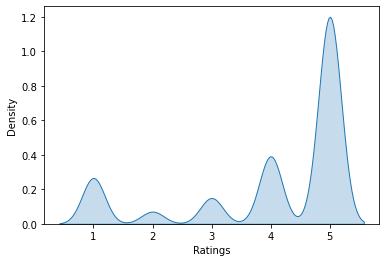

In [12]:
# Cheking data distribution of the Target Variable
sns.kdeplot(df["Ratings"],fill=True)

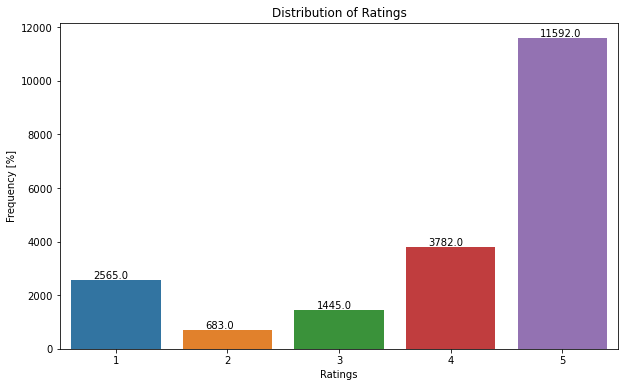

In [13]:
plt.figure(figsize=(10,6))
ax = sns.countplot(x="Ratings", data=df)
plt.title('Distribution of Ratings')
plt.xlabel('Ratings')
plt.ylabel('Frequency [%]')

for p in ax.patches:
        ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.2, p.get_height()+70))

`**From above graph we can see that there are rating 2 has the lowest count in the dataset we need to choose the the final model by keeping that in mind that there is class imbalanced in the dataset**

### Data Cleaning

In [14]:
# Cheking very first full reviews
df["Full Reviews"][0]

"Awesome Watch , More better than I ve expected, I m loving it 😀 it's look like my apple smartwatch , it's Amazing Experience flippant, its an outstanding product 😀 👌 with a low price , I think in this price range this is the best nd usefull thing flipkart ,Too good 👍 And too many Applications and things in this watch ⌚ just 👏 👏 👏 👏"

In [15]:
df["Full Reviews"][0]

"Awesome Watch , More better than I ve expected, I m loving it 😀 it's look like my apple smartwatch , it's Amazing Experience flippant, its an outstanding product 😀 👌 with a low price , I think in this price range this is the best nd usefull thing flipkart ,Too good 👍 And too many Applications and things in this watch ⌚ just 👏 👏 👏 👏"

In [16]:
# Cheking very first short reviews
df["Short Reviews"][0]

"['5', 'Excellent']"

In [17]:
df["Full Reviews"] = df["Full Reviews"].apply(lambda x: str(x))
df["Short Reviews"] = df["Short Reviews"].apply(lambda x: str(x))

In [18]:
# Create function to remove emoji and emoticons
def emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)


In [19]:
# Function To remove url, html text, Numeric character
def remove_URL(text):
    url = re.compile(r"https?://\s+|www\.\s+")
    return url.sub(r"",text)
    
def remove_html(text):
    html = re.compile(r"<.*?>")
    return html.sub(r"",text)


def removing_NumericCharacters(string):
    regex = "[0-9]"
    return (re.sub(regex, "", string))

In [20]:
# Applying above mention function on the dataset using map
df["Full Reviews"] = df["Full Reviews"].map(lambda x: remove_URL(x))
df["Full Reviews"] = df["Full Reviews"].map(lambda x: remove_html(x))
df["Full Reviews"] = df["Full Reviews"].map(lambda x: emoji(x))


df["Short Reviews"] = df["Short Reviews"].map(lambda x: remove_URL(x))
df["Short Reviews"] = df["Short Reviews"].map(lambda x: remove_html(x))
df["Short Reviews"] = df["Short Reviews"].map(lambda x: emoji(x))
df["Short Reviews"] = df["Short Reviews"].map(lambda x: removing_NumericCharacters(x))

In [21]:
# Performing further cleaning
lemmatizer = nltk.stem.WordNetLemmatizer()

def cleaning(df,stop_words):
    #Converting to lower case
    df["Full Reviews"] = df["Full Reviews"].str.lower()
    
    # Removing stopwords
    df["Full Reviews"] = df["Full Reviews"].apply(lambda x: " ".join(x for x in x.split() if x not in stop_words))
    
    # Lemmatization
    df["Full Reviews"] = df["Full Reviews"].apply(lambda x:" ".join([lemmatizer.lemmatize(x) for x in x.split()]))
    
    # Removing Punchuation
    df["Full Reviews"] = df["Full Reviews"].str.replace(r'[^\w\d\s]',"")
    
    # Removing Extra Whitespaces using split and join method
    df["Full Reviews"] = df["Full Reviews"].apply(lambda x:" ".join(x for x in x.split()))
    
    # Replacing Email address
    df["Full Reviews"]= df["Full Reviews"].str.replace(r'^.+@[^\.].*\.[a-z]{2,}$',"emailaddress")
    
    # Replacing \n
    df["Full Reviews"] = df["Full Reviews"].replace("\n"," ")
    
    return df

# I am appending few stopwords which people uses while writting any comment
stop_words = set(stopwords.words("english")+["aww","hmm","cant","dont","u","ur","4","d","e","im","hey","yo","ja"])
df = cleaning(df,stop_words)

In [22]:
lemmatizer = nltk.stem.WordNetLemmatizer()

def cleaning(df,stop_words):
    #Converting to lower case
    df["Short Reviews"] = df["Short Reviews"].str.lower()
    
    # Removing stopwords
    df["Short Reviews"] = df["Short Reviews"].apply(lambda x: " ".join(x for x in x.split() if x not in stop_words))
    
    # Lemmatization
    df["Short Reviews"] = df["Short Reviews"].apply(lambda x:" ".join([lemmatizer.lemmatize(x) for x in x.split()]))
    
    # Removing Punchuation
    df["Short Reviews"] = df["Short Reviews"].str.replace(r'[^\w\d\s]',"")
    
    # Removing Extra Whitespaces using split and join method
    df["Short Reviews"] = df["Short Reviews"].apply(lambda x:" ".join(x for x in x.split()))
    
    # Replacing Email address
    df["Short Reviews"]= df["Short Reviews"].str.replace(r'^.+@[^\.].*\.[a-z]{2,}$',"emailaddress")
    
    # Replacing \n
    df["Short Reviews"] = df["Short Reviews"].replace("\n"," ")
    
    return df

# I am appending few stopwords which people uses while writting any comment
stop_words = set(stopwords.words("english")+["aww","hmm","cant","dont","u","ur","4","d","e","im","hey","yo","ja"])
df = cleaning(df,stop_words)

In [23]:
# Checking Spelling and replacing it with the correct word using spellchecker
from spellchecker import SpellChecker

spell = SpellChecker()

df["Full Reviews"] = df["Full Reviews"].apply(lambda x:" ".join([spell.correction(x) for x in x.split()]))

In [24]:
# Creating new columns for EDA purpose
classification =[]
for i in df["Ratings"]:
    if i >= 3:
        classification.append("Good")
    else:
        classification.append("Bad")
        
df["Classification"] = classification

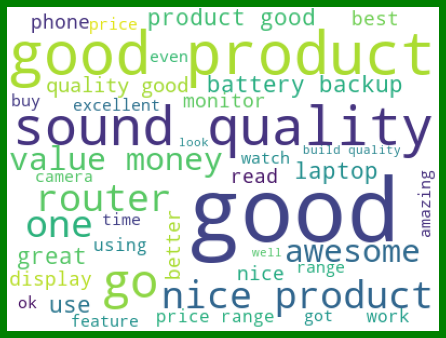

In [25]:
# Generating WordCloud for rating 3 and above
from wordcloud import WordCloud
def word_cloud(text,color):
    good = df["Full Reviews"][df["Classification"]==text]
    wordcloud = WordCloud(width=400,height=300,background_color='white',max_words=40).generate(" ".join(good))
    plt.figure(figsize=(6,8),facecolor=color)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.tight_layout(pad=0)
    return plt.show()

word_cloud("Good","g")

**For rating 3 and above we can see that words like nice product, good, quality is frequently.**

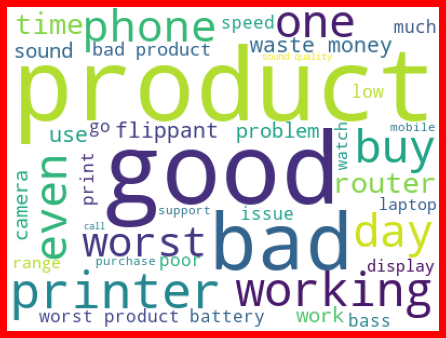

In [26]:
# Generating WordCloud for rating below 3
word_cloud("Bad","r")

**From above word cloud for rating below 3. we can see that there is word like working, product, Bad this kind of word used Frequently.**

In [27]:
# Defining Function to Generate Wordcloud of Short Reviews column
def Srt_wordcloud(text,color):
    rating = df["Short Reviews"][df["Classification"]==text]
    wordcloud = WordCloud(width=600,height=400,background_color='white',max_words=40).generate(" ".join(rating))
    plt.figure(figsize=(6,8),facecolor=color)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.tight_layout(pad=0)
    return plt.show()

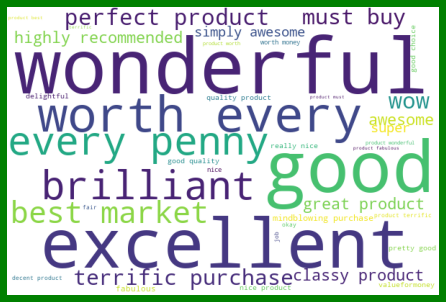

In [28]:
Srt_wordcloud("Good","g")

**If we just take a look at the Short reviews of the customer for the rating 3 and above we can see that they use the words like excellent, wonderful, good, worth, penny etc frequently.**

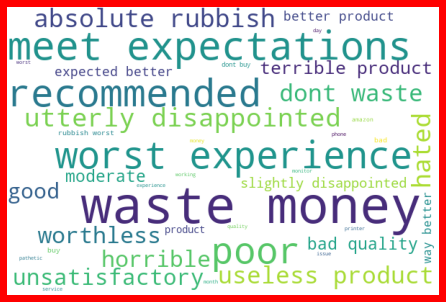

In [29]:
Srt_wordcloud("Bad","r")

**If we just take a look at the Short reviews of the customer for the rating below 3 we can see that they use the words like worst experience, waste money, good, poor, unsatisfactory etc frequently. We can also build a model which can take short reviews as input and generate output for us**

### I am dropping the short reviews here but if we want we can built the model on the basis of short reviews as well or we can merge the full review and short review if we want to continue building a model keeping both(i.e short and full reviews). 

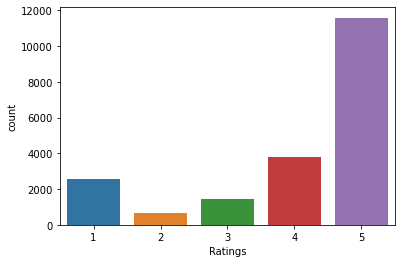

In [30]:
# Checking the data distribution of the target column
sns.countplot(df["Ratings"])
plt.show()

In [31]:
# Converting text into vectors
tf_vec = TfidfVectorizer()
features = tf_vec.fit_transform(df["Full Reviews"])

**As we can see that there is huge class imbalanced in the target columns so i am gonna consider F1 score for best model**

### Splitting Dataset

In [32]:
'''i have convert only Full Reviews columns in to vectors therefore there is no need to drop any other columns.
I have alread assign the required columns in x and y'''
x = features
y = df["Ratings"]

## Model Buiding

In [33]:
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier, GradientBoostingClassifier
from imblearn.ensemble import BalancedBaggingClassifier,BalancedRandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,classification_report,f1_score,confusion_matrix,plot_confusion_matrix

from sklearn.model_selection import train_test_split,cross_val_score

In [34]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=.25,stratify=y,shuffle=True,random_state=0)

In [63]:
a = []
c =[]
f = []

### MultinomialNB

In [64]:
mnb = MultinomialNB()
mnb.fit(x_train,y_train)

MultinomialNB()

In [65]:
y_pred = mnb.predict(x_test)

In [66]:
print("Accuracy Score is:",accuracy_score(y_test,y_pred),"\n","=-"*60,"\n",
      "Classification report :\n",classification_report(y_test,y_pred),
      "\n","=-"*60,"\n","Cross Validation Score :",cross_val_score(mnb,x,y,cv=5).mean())

Accuracy Score is: 0.6222842336057405 
 =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=- 
 Classification report :
               precision    recall  f1-score   support

           1       0.82      0.34      0.48       641
           2       0.00      0.00      0.00       171
           3       1.00      0.00      0.01       361
           4       0.83      0.02      0.03       946
           5       0.61      1.00      0.76      2898

    accuracy                           0.62      5017
   macro avg       0.65      0.27      0.25      5017
weighted avg       0.69      0.62      0.50      5017
 
 =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=- 
 Cross Validation Score : 0.6178808756941038


In [67]:
a.append(accuracy_score(y_test,y_pred))
c.append(cross_val_score(mnb,x,y,cv=5).mean())
f.append(f1_score(y_test,y_pred,average='weighted'))

In [68]:
confusion_matrix(y_test,y_pred)

array([[ 216,    0,    0,    0,  425],
       [  26,    0,    0,    0,  145],
       [  10,    0,    1,    1,  349],
       [   6,    0,    0,   15,  925],
       [   6,    0,    0,    2, 2890]], dtype=int64)

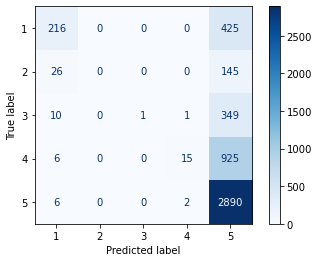

In [69]:
disp = plot_confusion_matrix(mnb, x_test, y_test,
                                 cmap=plt.cm.Blues)
plt.show()

### Bagging Classifier

In [70]:
bag_clf = BaggingClassifier()
        
bag_clf.fit(x_train,y_train)

BaggingClassifier()

In [71]:
y_pred = bag_clf.predict(x_test)

In [72]:
print("Accuracy Score is:",accuracy_score(y_test,y_pred),"\n","=-"*60,"\n",
      "Classification report :\n",classification_report(y_test,y_pred),"\n","=-"*60,
      "\n","Cross Validation Score :",cross_val_score(bag_clf,x,y,cv=5).mean())

Accuracy Score is: 0.6984253537970899 
 =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=- 
 Classification report :
               precision    recall  f1-score   support

           1       0.65      0.75      0.70       641
           2       0.45      0.17      0.25       171
           3       0.52      0.26      0.35       361
           4       0.54      0.32      0.40       946
           5       0.75      0.90      0.81      2898

    accuracy                           0.70      5017
   macro avg       0.58      0.48      0.50      5017
weighted avg       0.67      0.70      0.67      5017
 
 =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=- 
 Cross Validation Score : 0.6312347724901544


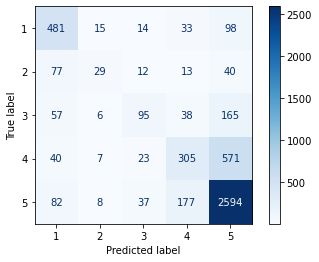

In [73]:
disp = plot_confusion_matrix(bag_clf, x_test, y_test,
                                 cmap=plt.cm.Blues)
plt.show()

In [74]:
a.append(accuracy_score(y_test,y_pred))
c.append(cross_val_score(bag_clf,x,y,cv=5).mean())
f.append(f1_score(y_test,y_pred,average='weighted'))

### Bernouli Naive Bayes Classifier

In [75]:
bernouli = BernoulliNB()
bernouli.fit(x_train,y_train)

BernoulliNB()

In [76]:
y_pred = bernouli.predict(x_test)

In [77]:
print("Accuracy Score is:",accuracy_score(y_test,y_pred),"\n","=-"*60,"\n",
      "Classification report :\n",classification_report(y_test,y_pred),
      "\n","=-"*60,"\n","Cross Validation Score :",cross_val_score(bernouli,x,y,cv=5).mean())

Accuracy Score is: 0.6053418377516444 
 =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=- 
 Classification report :
               precision    recall  f1-score   support

           1       0.75      0.39      0.51       641
           2       0.22      0.02      0.04       171
           3       0.26      0.12      0.17       361
           4       0.36      0.19      0.25       946
           5       0.64      0.88      0.74      2898

    accuracy                           0.61      5017
   macro avg       0.45      0.32      0.34      5017
weighted avg       0.56      0.61      0.55      5017
 
 =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=- 
 Cross Validation Score : 0.5786114783158024


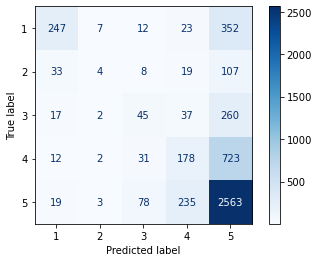

In [78]:
disp = plot_confusion_matrix(bernouli, x_test, y_test,
                                 cmap=plt.cm.Blues)
plt.show()

In [79]:
a.append(accuracy_score(y_test,y_pred))
c.append(cross_val_score(bernouli,x,y,cv=5).mean())
f.append(f1_score(y_test,y_pred,average='weighted'))

### RandomForest Classifier

In [80]:
rf = RandomForestClassifier()
rf.fit(x_train,y_train)

RandomForestClassifier()

In [81]:
y_pred = rf.predict(x_test)

In [82]:
print("Accuracy Score is:",accuracy_score(y_test,y_pred),"\n","=-"*60,"\n",
      "Classification report :\n",classification_report(y_test,y_pred),
      "\n","=-"*60,"\n","Cross Validation Score :",cross_val_score(rf,x,y,cv=5).mean())

Accuracy Score is: 0.7241379310344828 
 =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=- 
 Classification report :
               precision    recall  f1-score   support

           1       0.72      0.72      0.72       641
           2       0.70      0.20      0.32       171
           3       0.64      0.25      0.36       361
           4       0.82      0.25      0.39       946
           5       0.72      0.97      0.83      2898

    accuracy                           0.72      5017
   macro avg       0.72      0.48      0.52      5017
weighted avg       0.73      0.72      0.68      5017
 
 =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=- 
 Cross Validation Score : 0.6530623133014017


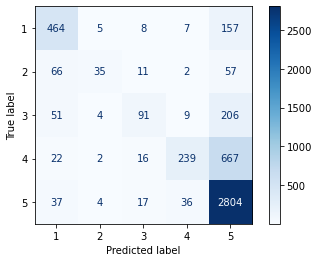

In [83]:
disp = plot_confusion_matrix(rf, x_test, y_test,
                                 cmap=plt.cm.Blues)
plt.show()

In [84]:
a.append(accuracy_score(y_test,y_pred))
c.append(cross_val_score(rf,x,y,cv=5).mean())
f.append(f1_score(y_test,y_pred,average='weighted'))

### CatBoostClassifier

In [85]:
from catboost import CatBoostClassifier

classifier = CatBoostClassifier(loss_function='MultiClass',depth=10,iterations=100)
classifier.fit(x_train,y_train)

Learning rate set to 0.5
0:	learn: 1.2037200	total: 5.57s	remaining: 9m 11s
1:	learn: 1.0927844	total: 11.2s	remaining: 9m 8s
2:	learn: 1.0540795	total: 17.1s	remaining: 9m 13s
3:	learn: 1.0147070	total: 22.9s	remaining: 9m 9s
4:	learn: 0.9913735	total: 28.8s	remaining: 9m 7s
5:	learn: 0.9748378	total: 35.2s	remaining: 9m 12s
6:	learn: 0.9688873	total: 41.5s	remaining: 9m 11s
7:	learn: 0.9562239	total: 47.9s	remaining: 9m 11s
8:	learn: 0.9499192	total: 54.5s	remaining: 9m 11s
9:	learn: 0.9392369	total: 1m 1s	remaining: 9m 10s
10:	learn: 0.9330033	total: 1m 7s	remaining: 9m 9s
11:	learn: 0.9283788	total: 1m 14s	remaining: 9m 6s
12:	learn: 0.9209997	total: 1m 21s	remaining: 9m 3s
13:	learn: 0.9113062	total: 1m 27s	remaining: 9m
14:	learn: 0.9072098	total: 1m 34s	remaining: 8m 56s
15:	learn: 0.9008529	total: 1m 41s	remaining: 8m 52s
16:	learn: 0.8949222	total: 1m 48s	remaining: 8m 48s
17:	learn: 0.8924675	total: 1m 55s	remaining: 8m 44s
18:	learn: 0.8890636	total: 2m 1s	remaining: 8m 38s


In [86]:
y_pred = classifier.predict(x_test)

In [87]:
cv = cross_val_score(classifier,x,y,cv=5).mean()

Learning rate set to 0.5
0:	learn: 1.1754664	total: 6.67s	remaining: 11m
1:	learn: 1.0772429	total: 13.6s	remaining: 11m 7s
2:	learn: 1.0349176	total: 20.3s	remaining: 10m 56s
3:	learn: 1.0030964	total: 27.3s	remaining: 10m 54s
4:	learn: 0.9835999	total: 34.1s	remaining: 10m 47s
5:	learn: 0.9696497	total: 40.8s	remaining: 10m 38s
6:	learn: 0.9614027	total: 47.7s	remaining: 10m 33s
7:	learn: 0.9519551	total: 54.4s	remaining: 10m 25s
8:	learn: 0.9482258	total: 1m 1s	remaining: 10m 19s
9:	learn: 0.9379631	total: 1m 7s	remaining: 10m 11s
10:	learn: 0.9308322	total: 1m 14s	remaining: 10m 5s
11:	learn: 0.9278930	total: 1m 21s	remaining: 9m 58s
12:	learn: 0.9221601	total: 1m 28s	remaining: 9m 51s
13:	learn: 0.9190549	total: 1m 35s	remaining: 9m 45s
14:	learn: 0.9138827	total: 1m 42s	remaining: 9m 38s
15:	learn: 0.9096739	total: 1m 49s	remaining: 9m 32s
16:	learn: 0.9051204	total: 1m 55s	remaining: 9m 25s
17:	learn: 0.9023922	total: 2m 3s	remaining: 9m 20s
18:	learn: 0.8988048	total: 2m 9s	rem

56:	learn: 0.7964055	total: 6m 17s	remaining: 4m 44s
57:	learn: 0.7943228	total: 6m 24s	remaining: 4m 38s
58:	learn: 0.7938255	total: 6m 30s	remaining: 4m 31s
59:	learn: 0.7928521	total: 6m 37s	remaining: 4m 25s
60:	learn: 0.7902198	total: 6m 44s	remaining: 4m 18s
61:	learn: 0.7867710	total: 6m 51s	remaining: 4m 11s
62:	learn: 0.7856947	total: 6m 58s	remaining: 4m 5s
63:	learn: 0.7848502	total: 7m 4s	remaining: 3m 58s
64:	learn: 0.7838982	total: 7m 11s	remaining: 3m 52s
65:	learn: 0.7833662	total: 7m 18s	remaining: 3m 45s
66:	learn: 0.7816150	total: 7m 25s	remaining: 3m 39s
67:	learn: 0.7810322	total: 7m 32s	remaining: 3m 32s
68:	learn: 0.7802436	total: 7m 38s	remaining: 3m 26s
69:	learn: 0.7783813	total: 7m 46s	remaining: 3m 19s
70:	learn: 0.7771534	total: 7m 52s	remaining: 3m 13s
71:	learn: 0.7761784	total: 7m 59s	remaining: 3m 6s
72:	learn: 0.7749643	total: 8m 6s	remaining: 2m 59s
73:	learn: 0.7736247	total: 8m 13s	remaining: 2m 53s
74:	learn: 0.7701731	total: 8m 19s	remaining: 2m 4

12:	learn: 0.9151332	total: 2m 7s	remaining: 14m 14s
13:	learn: 0.9082892	total: 2m 17s	remaining: 14m 3s
14:	learn: 0.9025361	total: 2m 27s	remaining: 13m 54s
15:	learn: 0.8929498	total: 2m 36s	remaining: 13m 39s
16:	learn: 0.8894435	total: 2m 44s	remaining: 13m 25s
17:	learn: 0.8853710	total: 2m 54s	remaining: 13m 15s
18:	learn: 0.8815197	total: 3m 3s	remaining: 13m 3s
19:	learn: 0.8744434	total: 3m 12s	remaining: 12m 49s
20:	learn: 0.8709978	total: 3m 22s	remaining: 12m 39s
21:	learn: 0.8664479	total: 3m 31s	remaining: 12m 28s
22:	learn: 0.8623441	total: 3m 39s	remaining: 12m 16s
23:	learn: 0.8585879	total: 3m 49s	remaining: 12m 7s
24:	learn: 0.8568395	total: 3m 59s	remaining: 11m 58s
25:	learn: 0.8529142	total: 4m 8s	remaining: 11m 46s
26:	learn: 0.8500620	total: 4m 18s	remaining: 11m 37s
27:	learn: 0.8431921	total: 4m 28s	remaining: 11m 31s
28:	learn: 0.8397981	total: 4m 39s	remaining: 11m 24s
29:	learn: 0.8369655	total: 4m 49s	remaining: 11m 16s
30:	learn: 0.8340711	total: 4m 59s

67:	learn: 0.7605422	total: 8m 40s	remaining: 4m 5s
68:	learn: 0.7571716	total: 8m 47s	remaining: 3m 56s
69:	learn: 0.7564801	total: 8m 54s	remaining: 3m 48s
70:	learn: 0.7559172	total: 9m 2s	remaining: 3m 41s
71:	learn: 0.7537256	total: 9m 8s	remaining: 3m 33s
72:	learn: 0.7525965	total: 9m 15s	remaining: 3m 25s
73:	learn: 0.7519302	total: 9m 21s	remaining: 3m 17s
74:	learn: 0.7513055	total: 9m 28s	remaining: 3m 9s
75:	learn: 0.7502856	total: 9m 34s	remaining: 3m 1s
76:	learn: 0.7483879	total: 9m 41s	remaining: 2m 53s
77:	learn: 0.7474411	total: 9m 47s	remaining: 2m 45s
78:	learn: 0.7449572	total: 9m 54s	remaining: 2m 37s
79:	learn: 0.7443597	total: 10m	remaining: 2m 30s
80:	learn: 0.7435155	total: 10m 7s	remaining: 2m 22s
81:	learn: 0.7421790	total: 10m 13s	remaining: 2m 14s
82:	learn: 0.7414857	total: 10m 19s	remaining: 2m 6s
83:	learn: 0.7406674	total: 10m 26s	remaining: 1m 59s
84:	learn: 0.7402658	total: 10m 32s	remaining: 1m 51s
85:	learn: 0.7395932	total: 10m 39s	remaining: 1m 4

In [88]:
print("Accuracy Score is:",accuracy_score(y_test,y_pred),"\n","=-"*60,"\n",
      "Classification report :\n",classification_report(y_test,y_pred),
      "\n","=-"*60,"\n","Cross Validation Score :",cv)

Accuracy Score is: 0.6751046442096871 
 =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=- 
 Classification report :
               precision    recall  f1-score   support

           1       0.68      0.65      0.66       641
           2       0.67      0.04      0.07       171
           3       0.46      0.15      0.23       361
           4       0.51      0.15      0.23       946
           5       0.69      0.96      0.80      2898

    accuracy                           0.68      5017
   macro avg       0.60      0.39      0.40      5017
weighted avg       0.64      0.68      0.61      5017
 
 =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=- 
 Cross Validation Score : 0.6510685439238271


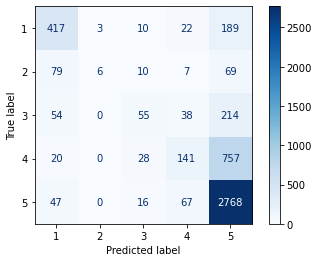

In [89]:
disp = plot_confusion_matrix(classifier, x_test, y_test,
                                 cmap=plt.cm.Blues)
plt.show()

In [90]:
a.append(accuracy_score(y_test,y_pred))
c.append(cv)
f.append(f1_score(y_test,y_pred,average='weighted'))

### SVM

In [101]:
svc = SVC(probability=True)
svc.fit(x_train,y_train)

SVC()

In [102]:
y_pred = svc.predict(x_test)

In [109]:
print("Accuracy Score is:",accuracy_score(y_test,y_pred),"\n","=-"*60,"\n",
      "Classification report :\n",classification_report(y_test,y_pred),
      "\n","=-"*60,"\n","Cross Validation Score :",cross_val_score(svc,x,y,cv=5).mean())

Accuracy Score is: 0.71038469204704 
 =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=- 
 Classification report :
               precision    recall  f1-score   support

           1       0.72      0.73      0.73       641
           2       0.83      0.12      0.21       171
           3       0.66      0.20      0.30       361
           4       0.81      0.17      0.28       946
           5       0.70      0.98      0.82      2898

    accuracy                           0.71      5017
   macro avg       0.75      0.44      0.47      5017
weighted avg       0.73      0.71      0.65      5017
 
 =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=- 
 Cross Validation Score : 0.6609854048085626


In [ ]:
disp = plot_confusion_matrix(svc, x_test, y_test,
                                 cmap=plt.cm.Blues)
plt.show()

In [110]:
a.append(accuracy_score(y_test,y_pred))
c.append(cross_val_score(svc,x,y,cv=5).mean())
f.append(f1_score(y_test,y_pred,average='weighted'))

In [200]:
model = ["MultnomialNB","Bagging classifier","Bernouli Naive bayes","RandomForest Classifier","CatBoostClassifier","SVC"]

best_model=pd.DataFrame({"Model":model,"Accuracy score":a,"Cross Validation Score":c,"F1 score":f})
best_model

,Model,Accuracy score,Cross Validation Score,F1 score
0,MultnomialNB,0.622284,0.617881,0.504720
1,Bagging classifier,0.698425,0.632880,0.669942
2,Bernouli Naive bayes,0.605342,0.578611,0.554302
3,RandomForest Classifier,0.724138,0.652813,0.677735
4,CatBoostClassifier,0.675105,0.651069,0.610799
5,SVC,0.710385,0.660985,0.648653


As we know when that when the dataset is imbalanced at that time we need to consider **F1 Score** to choose the Best Model. **I have calculate weighted F1 Score for all the model because it take class imbalance into account**. Here that model is **RandomForest Classifier**. So i am gonna tune that RandomForest with best parameter using hyperparameter Tunning.**

### Hyperparameter Tunning

In [206]:
params = {"criterion":['gini','entropy'],
         "random_state":[0,143],
         "n_estimators":[100,200],
         "max_depth":[3,10,None]}

In [207]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
rand_search = RandomizedSearchCV(rf,param_distributions=params,cv=3,n_jobs=-1)

In [208]:
rand_search.fit(x_train,y_train)

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [3, 10, None],
                                        'n_estimators': [100, 200],
                                        'random_state': [0, 143]})

In [209]:
rand_search.best_params_

{'random_state': 0,
 'n_estimators': 200,
 'max_depth': None,
 'criterion': 'entropy'}

In [211]:
rf = RandomForestClassifier(random_state=0,n_estimators=200,max_depth=None,criterion='entropy')

In [212]:
rf.fit(x_train,y_train)

RandomForestClassifier(criterion='entropy', n_estimators=200, random_state=0)

In [213]:
y_pred = rf.predict(x_test)

In [214]:
accuracy_score(y_test,y_pred)

0.725134542555312

In [215]:
f1_score(y_test,y_pred,average='weighted')

0.6787631478844812

In [216]:
print("\n",classification_report(y_test,y_pred))


               precision    recall  f1-score   support

           1       0.74      0.73      0.73       641
           2       0.70      0.20      0.32       171
           3       0.64      0.25      0.36       361
           4       0.83      0.25      0.38       946
           5       0.72      0.97      0.83      2898

    accuracy                           0.73      5017
   macro avg       0.73      0.48      0.52      5017
weighted avg       0.74      0.73      0.68      5017



In [217]:
print("Cross Validation Score :",cross_val_score(rf,x,y,cv=5).mean())

Cross Validation Score : 0.6539095473343919


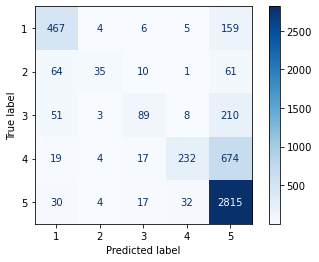

In [219]:
disp = plot_confusion_matrix(rf, x_test, y_test,cmap=plt.cm.Blues)
plt.show()

In [238]:
from sklearn.metrics import roc_curve,roc_auc_score,plot_roc_curve
#Bagging Classifier
print("Bagging Classifier roc_auc_score",roc_auc_score(y_test,bag_clf.predict_proba(x_test),multi_class='ovr', average='weighted'))

#MultinomialNB
print("MultinomialNB roc_auc_score",roc_auc_score(y_test,mnb.predict_proba(x_test),multi_class='ovr', average='weighted'))

#BernoulliNB Classifier
print("BernoulliNB Classifier roc_auc_score",roc_auc_score(y_test,bernouli.predict_proba(x_test),multi_class='ovr', average='weighted'))

#Random Forest Classifier
print("Random Forest Classifier roc_auc_score",roc_auc_score(y_test,rf.predict_proba(x_test),multi_class='ovr', average='weighted'))

#CatBoostClassifier
print("CatBoostClassifier roc_auc_score",roc_auc_score(y_test,classifier.predict_proba(x_test),multi_class='ovr', average='weighted'))

#svc
print("svc roc_auc_score",roc_auc_score(y_test,svc.predict_proba(x_test),multi_class='ovr', average='weighted'))

Bagging Classifier roc_auc_score 0.7592052223231919
MultinomialNB roc_auc_score 0.7592052223231919
BernoulliNB Classifier roc_auc_score 0.7307212413529234
Random Forest Classifier roc_auc_score 0.8418235144668076
CatBoostClassifier roc_auc_score 0.8065611132798124
svc roc_auc_score 0.8237565130782101


In [239]:
import pickle
pickle.dump(rf,open("Ratings_prediction.pk1","wb"))

In [240]:
load_model = pickle.load(open("Ratings_prediction.pk1","rb"))